# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sub
import dash
from dash import dcc, html, Output, Input, State
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.trial import TrialState
#from optuna.integration import PyTorchIgnitePruningHandler

from functools import partial
import random
import os
import itertools
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision.models import vgg16_bn, resnet50, resnet18, efficientnet_b0, densenet121, ResNet50_Weights, ResNet18_Weights, VGG16_BN_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks, draw_keypoints
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, ToPILImage
from torchvision.io import decode_image

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
# from ignite.handlers import ModelCheckpoint, EarlyStopping

from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from huggingface_hub import snapshot_download, hf_hub_download
import socket
import json
import sys
import io
import base64

# Load src files

In [36]:
os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

'c:\\Users\\chihp\\UMich\\SIADS\\GitHub\\CV_aircraft_classifier_capstone_project'

In [2]:
# Starting from chocp/, go up two levels to parent_dir/
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Prepend to sys.path so Python can find src/
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)



from src.chocp_dataset import FGVCAircraftDataset

# Define CUDA GPU, Class and Functions

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Simple CNN Backbone
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=30, attention_module=None):#, p_conv = 0.2, p_fc = 0.5
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 224x224 -> 224x224
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112
            #nn.Dropout2d(p_conv), # spatial dropout

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 112x112
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 56x56
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28
            #nn.Dropout2d(p_conv),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  # 14x14
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # B, 1024, 1, 1
        )
        self.attention = attention_module(1024) if attention_module else nn.Identity() #if attention_module else nn.Identity()
        #self.dropout_fc = nn.Dropout(p_fc)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x) #Bx1024x1x1
        #if self.attention:
        x = self.attention(x) # or Identity
        x = x.view(x.size(0), -1) #Bx1024
        #x = self.dropout_fc(x)
        x = self.classifier(x)
        return x

In [6]:
#BCNN Module
class BCNN(nn.Module):
    def __init__(self, num_classes=30, attention_module=None):
        super(BCNN, self).__init__()

        # Custom feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B, 64, 224, 224]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 112, 112]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# [B, 128, 112, 112]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 128, 56, 56]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# [B, 256, 56, 56]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                 # [B, 256, 1, 1]
        )
        
        self.attention = attention_module(256) if attention_module else nn.Identity()
        self.output_dim = 256
        self.fc = nn.Linear(self.output_dim * self.output_dim, num_classes)

    def forward(self, x):
        x = self.features(x)  # [B, 256, 1, 1]
        x = self.attention(x) # Apply attention if provided
        x = x.view(x.size(0), self.output_dim)  # [B, 256]

        # Bilinear pooling
        x = torch.bmm(x.unsqueeze(2), x.unsqueeze(1))  # [B, 256, 256]
        x = x.view(x.size(0), -1)  # [B, 256*256]

        # Signed square root normalization
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)

        # L2 normalization
        x = F.normalize(x)

        # Classification
        x = self.fc(x)
        return x

In [7]:
# CAP Module
class CAP(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CAP, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        context = self.global_avg_pool(x)
        attention = self.fc1(context)
        attention = self.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention)
        return x * attention

# SE Module
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        channel_att = self.sigmoid_channel(avg_out + max_out)
        x = x * channel_att

        # Spatial Attention
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.cat([avg_pool, max_pool], dim=1)
        spatial_att = self.sigmoid_spatial(self.conv_spatial(spatial_att))
        x = x * spatial_att

        return x

In [8]:
class CAPResNet(nn.Module):
    def __init__(self, num_classes=30, drop=0.0):
        super(CAPResNet, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.cap = CAP(in_channels=2048)
        self.dropout = nn.Dropout(drop)
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.cap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


# ResNet50 with SE Block
class SEEffNet(nn.Module):
    def __init__(self, num_classes=30, drop=0.0):
        super(SEEffNet, self).__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity() # fc if resnet
        self.se = SEBlock(in_channels=1280) #2048 for resnet, 1280 for efficientnet, densenet121 = 1024, final layer also classifier
        self.dropout = nn.Dropout(drop)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.se(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# ResNet50 with CBAM Block
class CBAMResNet(nn.Module):
    def __init__(self, num_classes=30):
        super(CBAMResNet, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.cbam = CBAM(in_channels=2048)
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.cbam(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# ResNet50 with BCNN Block (Bilinear CNN)
class BCNNResNet(nn.Module):
    def __init__(self, num_classes=30):
        super(BCNNResNet, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity() # Remove final fully connected layer
        self.output_dim = 2048 # resnet50 final feature depth
        self.classifier = nn.Linear(self.output_dim * self.output_dim, num_classes)

    def forward(self, x):
        x = self.backbone(x) # extract features Bx2048
        x = x.unsqueeze(-1).unsqueeze(-1) # Bx2048x1x1
        x = x.view(x.size(0), self.output_dim) # Bx2048
        x = torch.bmm(x.unsqueeze(2), x.unsqueeze(1)) # Bilinear pooling
        x = x.view(x.size(0), -1) # Bx2048*2048
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10) # signed square root normalization
        x = F.normalize(x) # L2 normalization
        x = self.classifier(x) # classification
        return x

In [9]:
# Loss functions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, pred, target):
        ce_loss = nn.functional.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [10]:
def get_loaders(img_size = 224, batch_size = 32, annot = 'manufacturer'):
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]

    train_tf = A.Compose([
        A.RandomResizedCrop((img_size, img_size)),  # A.Resize(img_size, img_size)
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    test_tf = A.Compose([
        #A.LongestMaxSize(max_size=256)
        A.Resize(img_size, img_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    
    train_dataset = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", split='train', level = annot, transform=train_tf, 
                                        return_class=False, cropped=True, album = True)
    val_dataset   = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", split='val', level = annot, transform=test_tf, 
                                        return_class=False, cropped=False, album = True)
    test_dataset   = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", split='test', level = annot, transform=test_tf, 
                                         return_class=False, cropped=False, album = True)
    class_names = train_dataset.classes
    num_classes = len(train_dataset.classes)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, num_classes, class_names

In [11]:
def get_datasets(img_size = 224, batch_size = 32, annot = 'manufacturer'):
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]

    train_tf = A.Compose([
        A.RandomResizedCrop((img_size, img_size)),  # A.Resize(img_size, img_size)
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    test_tf = A.Compose([
        #A.LongestMaxSize(max_size=256)
        A.Resize(img_size, img_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    
    train_dataset = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", split='train', level = annot, transform=train_tf, 
                                        return_class=False, cropped=True, album = True)
    val_dataset   = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", split='val', level = annot, transform=test_tf, 
                                        return_class=False, cropped=False, album = True)
    test_dataset   = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", split='test', level = annot, transform=test_tf, 
                                         return_class=False, cropped=False, album = True)
    class_names = train_dataset.classes
    num_classes = len(train_dataset.classes)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_dataset, val_dataset, test_dataset

In [12]:
# For evaluation of final test set

def compute_metrics(y_true, y_pred_logits, k=5):
    """
    Computes Top-1 and Top-k accuracy, and macro/micro F1 scores.
    
    Parameters:
    - y_true: Ground truth labels (list or numpy array)
    - y_pred_logits: Model output logits (tensor or numpy array)
    - k: Value for Top-k accuracy
    
    Returns:
    - Dictionary of metrics
    """
    # Convert logits to predicted labels
    y_pred_top1 = torch.argmax(y_pred_logits, dim=1).cpu().numpy()
    y_true_np = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    y_pred_np = y_pred_logits.cpu().numpy() if isinstance(y_pred_logits, torch.Tensor) else y_pred_logits

    # Compute metrics
    top1_acc = top_k_accuracy_score(y_true_np, y_pred_np, k=1)
    topk_acc = top_k_accuracy_score(y_true_np, y_pred_np, k=k)
    f1_macro = f1_score(y_true_np, y_pred_top1, average='macro')
    f1_micro = f1_score(y_true_np, y_pred_top1, average='micro')

    return {
        'Top-1 Accuracy': top1_acc,
        f'Top-{k} Accuracy': topk_acc,
        'F1 Macro': f1_macro,
        'F1 Micro': f1_micro
    }



In [13]:
# Training and evaluation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loss_lst = []
    acc_lst = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        #inputs, labels = cutmix_or_mixup(inputs, labels)#cutmix/mixup
        inputs, labels = inputs.to(device), labels.to(device)
        #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup

        optimizer.zero_grad()
        outputs = model(inputs)#
        loss = criterion(outputs, labels)#
        loss.backward()#
        optimizer.step()#
        # with autocast(device_type = 'cuda'):
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        

        running_loss += loss.item() * inputs.size(0)
        #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        loss_lst.append(loss.item() * inputs.size(0))#
        acc_lst.append(predicted.eq(labels).sum().item() / labels.size(0))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    #loss_lst.append(epoch_loss)
    #acc_lst.append(epoch_acc)
    return epoch_loss, epoch_acc, loss_lst, acc_lst

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    loss_lst = []
    acc_lst = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc = "Evaluation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            

            running_loss += loss.item() * inputs.size(0)
            #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss_lst.append(loss.item() * inputs.size(0))#
            acc_lst.append(predicted.eq(labels).sum().item() / labels.size(0))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    #loss_lst.append(epoch_loss)
    #acc_lst.append(epoch_acc)
    return epoch_loss, epoch_acc, all_preds, all_labels, loss_lst, acc_lst

In [14]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def unnormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def visualize_predictions(model, test_dataset, num_samples=10, normalized=True):
    model.eval()
    samples = random.sample(range(len(test_dataset)), num_samples)
    cols = 5
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    inv_label_map = test_dataset.idx_to_class
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():
        for idx, sample_idx in enumerate(samples):
            image, label = test_dataset[sample_idx]
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            # Unnormalize if needed
            if normalized:
                image = unnormalize(image.clone(), mean, std)

            img_disp = image.permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axes[idx].imshow(img_disp)
            axes[idx].set_title(f"Pred: {inv_label_map[pred.item()]}\nActual: {inv_label_map[label]}")
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
# Model selector
def get_model(backbone_name, num_classes, dropout_rate):
    if backbone_name == "ResNet50_CAP":
        return CAPResNet(num_classes=num_classes, drop=dropout_rate)
    elif backbone_name == "EffNet_SE":
        return SEEffNet(num_classes=num_classes, drop=dropout_rate)
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

# Objective function
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    backbone_name = trial.suggest_categorical('backbone', ['ResNet50_CAP', 'EffNet_SE'])
    scheduler_name = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau'])
    criterion_name = trial.suggest_categorical('criterion', ['CrossEntropy', 'LabelSmoothing', 'Focal'])

    # Data
    train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(img_size=224, batch_size=batch_size, annot='variant')

    # Model
    model = get_model(backbone_name, num_classes, dropout_rate)
    model.to(device)

    # Optimizer
    optimizer_cls = getattr(optim, optimizer_name)
    optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    if scheduler_name == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif scheduler_name == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    # Criterion with hyperparameters
    if criterion_name == 'CrossEntropy':
        label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    elif criterion_name == 'LabelSmoothing':
        smoothing = trial.suggest_float('smoothing', 0.05, 0.2)
        criterion = LabelSmoothingCrossEntropy(smoothing=smoothing)
    elif criterion_name == 'Focal':
        gamma = trial.suggest_float('gamma', 1.0, 3.0)
        criterion = FocalLoss(gamma=gamma)

    scaler = GradScaler('cuda')

    # Training loop
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    num_epochs = 20
    for epoch in range(num_epochs):
        train_loss, train_acc, _, _ = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, _, _, _, _ = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            print("✅ Model improved. Saving...")
        else:
            epochs_without_improvement += 1
            print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")
        if epochs_without_improvement >= patience:
            print("⏹️ Early stopping triggered.")
            break

    return val_acc


# Optuna Hyperparameters Searching.
# !!! Warning may take up 10+ hours, uncomment to execute

In [26]:
# study = optuna.create_study(study_name="Finest_FGVCAircraft_Variant", direction='maximize', 
#                             pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3, interval_steps=2))
# study.optimize(objective, timeout=None, n_jobs=1, n_trials=30, gc_after_trial=False, show_progress_bar=True)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Accuracy: {trial.value}")
# print("  Params:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")



# Optuna Visualization

In [16]:
# # Visualize optimization results
# optuna.visualization.plot_optimization_history(study, target_name='Accuracy', error_bar=True).show()
# optuna.visualization.plot_param_importances(study).show() # params=["x", "y"]
# optuna.visualization.plot_parallel_coordinate(study, target_name='Accuracy').show()
# optuna.visualization.plot_slice(study, target_name='Accuracy').show()
# optuna.visualization.plot_contour(study, target_name = 'Accuracy').show()
# optuna.visualization.plot_edf(study, target_name = 'Accuracy').show()
# optuna.visualization.plot_intermediate_values(study).show()
# optuna.visualization.plot_rank(study, target_name = 'Accuracy').show()
# optuna.visualization.timeline(study).show()

In [17]:
# # Plot with custom labels
# plt.plot(range(len([t.value for t in study.trials if t.value is not None])), [t.value for t in study.trials if t.value is not None], marker='o')
# plt.xlabel("Trial")
# plt.ylabel("Validation Accuracy")
# plt.title("Optimization History")
# plt.grid(True)

# Instantiating variables

In [18]:
train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(224,16,'variant')
train_dataset, val_dataset, test_dataset = get_datasets(224,16,'variant')

In [19]:
num_classes

100

In [20]:
for i, j in train_dataset:
    #plt.imshow(i)
    print(i.shape, j)
    break

torch.Size([3, 224, 224]) 0


In [21]:
train_dataset.idx_to_class[5]

'737-500'

# Hyperparameters applied from Optuna results

In [22]:
model=CAPResNet(num_classes, drop = 0.3563).to(device)
# Training loop with early stopping and adaptive learning rate
patience = 6
best_val_loss = float('inf')
epochs_without_improvement = 0
num_epochs = 30
criterion = nn.CrossEntropyLoss(label_smoothing = 0.046858)
optimizer = optim.Adam(model.parameters(), lr=5.1872e-05, weight_decay=0.002925) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# optimizer = optim.RMSprop(model.parameters(), lr=4.9122e-05, weight_decay=0.000126)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
scaler = GradScaler('cuda')

In [23]:
# #criterion = SoftTargetCrossEntropy() # or nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()#label_smoothing = 0.1)
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
# #optimizer = optim.AdamW(model.parameters(), lr=0.000085, weight_decay = 0.000009)#70
# #optimizer = optim.AdamW(model.parameters(), lr=0.000238, weight_decay = 0.00052)#30
# #optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# #optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
# #optimizer = optim.SGD(filter(lambda p: p.requires_grad, res50.parameters()), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Model Training Loop with Training and Validation dataset

In [24]:
%%time
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
all_val_preds = []
all_val_labels = []


for epoch in range(num_epochs):

    train_loss, train_acc, t_loss_lst, t__acc_lst = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, val_preds, val_labels, v_loss_lst, v_acc_lst = evaluate(model, val_loader, criterion, device)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    
    all_val_preds.extend(val_preds)
    all_val_labels.extend(val_labels)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # Step the scheduler
    #scheduler.step()#
    scheduler.step(val_loss) # only for 'ReduceLROnPlateau'

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        print("✅ Model improved. Saving...")
    else:
        epochs_without_improvement += 1
        print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("⏹️ Early stopping triggered.")
        break


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/30
Train Loss: 4.5876, Train Acc: 0.0237
Val Loss: 4.4743, Val Acc: 0.0423
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/30
Train Loss: 4.2630, Train Acc: 0.0786
Val Loss: 3.9330, Val Acc: 0.1527
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/30
Train Loss: 3.6915, Train Acc: 0.1662
Val Loss: 3.2901, Val Acc: 0.2343
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/30
Train Loss: 3.1108, Train Acc: 0.2756
Val Loss: 2.7718, Val Acc: 0.3213
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/30
Train Loss: 2.6993, Train Acc: 0.3533
Val Loss: 2.4916, Val Acc: 0.3885
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/30
Train Loss: 2.4176, Train Acc: 0.4196
Val Loss: 2.2383, Val Acc: 0.4413
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/30
Train Loss: 2.2195, Train Acc: 0.4748
Val Loss: 2.0906, Val Acc: 0.4797
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/30
Train Loss: 2.0282, Train Acc: 0.5228
Val Loss: 1.9993, Val Acc: 0.4971
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/30
Train Loss: 1.8649, Train Acc: 0.5636
Val Loss: 1.9244, Val Acc: 0.5182
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/30
Train Loss: 1.7552, Train Acc: 0.6032
Val Loss: 1.8041, Val Acc: 0.5530
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/30
Train Loss: 1.6724, Train Acc: 0.6311
Val Loss: 1.7201, Val Acc: 0.5812
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/30
Train Loss: 1.5589, Train Acc: 0.6641
Val Loss: 1.7152, Val Acc: 0.5857
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/30
Train Loss: 1.4948, Train Acc: 0.6842
Val Loss: 1.7341, Val Acc: 0.5782
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/30
Train Loss: 1.4228, Train Acc: 0.7079
Val Loss: 1.7028, Val Acc: 0.5929
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/30
Train Loss: 1.3844, Train Acc: 0.7133
Val Loss: 1.6193, Val Acc: 0.6106
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/30
Train Loss: 1.3252, Train Acc: 0.7373
Val Loss: 1.6037, Val Acc: 0.6229
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/30
Train Loss: 1.2917, Train Acc: 0.7504
Val Loss: 1.6048, Val Acc: 0.6199
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/30
Train Loss: 1.2814, Train Acc: 0.7537
Val Loss: 1.5551, Val Acc: 0.6388
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/30
Train Loss: 1.2051, Train Acc: 0.7819
Val Loss: 1.6047, Val Acc: 0.6166
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/30
Train Loss: 1.1641, Train Acc: 0.7885
Val Loss: 1.6406, Val Acc: 0.6109
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 21/30
Train Loss: 1.1798, Train Acc: 0.7891
Val Loss: 1.5669, Val Acc: 0.6277
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 22/30
Train Loss: 1.1559, Train Acc: 0.7987
Val Loss: 1.6448, Val Acc: 0.6172
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 23/30
Train Loss: 1.1039, Train Acc: 0.8116
Val Loss: 1.6357, Val Acc: 0.6292
⚠️ No improvement for 5 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 24/30
Train Loss: 1.1054, Train Acc: 0.8125
Val Loss: 1.5815, Val Acc: 0.6328
⚠️ No improvement for 6 epoch(s).
⏹️ Early stopping triggered.
CPU times: total: 9h 18min 1s
Wall time: 2d 48min 38s


# Final Generalization with Test dataset

In [25]:
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Evaluation", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_preds.append(outputs.cpu())
        final_labels.append(labels.cpu())

final_preds = torch.cat(final_preds)
final_labels = torch.cat(final_labels)

final_metrics = compute_metrics(final_labels, final_preds, k=5)
print("Final Evaluation Metrics:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")

Final Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Final Evaluation Metrics:
Top-1 Accuracy: 0.6298
Top-5 Accuracy: 0.8962
F1 Macro: 0.6263
F1 Micro: 0.6298


# Plotting Confusion Matrix and Lollipop Scatter plot

In [26]:
cm = confusion_matrix(all_val_labels, all_val_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracy = np.diag(cm_normalized)
tick_marks = np.arange(len(class_names))

In [27]:
# Create heatmap using Plotly
heatmap = go.Heatmap(
    z=cm_normalized,
    x=class_names,
    y=class_names,
    colorscale='Plasma',
    colorbar=dict(title='Accuracy'),
    hovertemplate='Actual: %{y}<br>Predicted: %{x}<br>Accuracy: %{z:.2%}<extra></extra>'
)

# Create scatter plot (lollipop style) for class accuracy
scatter = go.Scatter(
    x=class_names,
    y=class_accuracy,
    mode='markers+lines',
    marker=dict(size=8, color='blue'),
    line=dict(color='lightblue'),
    name='Class Accuracy',
    hovertemplate='Class: %{x}<br>Accuracy: %{y:.2%}<extra></extra>'
)

# Create subplots with corrected keyword 'shared_xaxes'
fig = sub.make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Normalized Confusion Matrix", "Accuracy per Class")
)

fig.add_trace(heatmap, row=1, col=1)
fig.add_trace(scatter, row=2, col=1)

fig.update_layout(
    height=1000,
    width=1200,
    title_text="Interactive Confusion Matrix with Class Accuracy",
    xaxis2=dict(tickangle=90),
    margin=dict(t=100)
)

fig.write_html("interactive_confusion_matrix.html")
print("Interactive confusion matrix with class accuracy saved as 'interactive_confusion_matrix.html'.")
fig.show()


Interactive confusion matrix with class accuracy saved as 'interactive_confusion_matrix.html'.


# Have a glance for Best and Worst 5 classes of prediction

In [28]:
# Zip the class names and accuracies
zipped = list(zip(class_names, class_accuracy))

# Sort by accuracy
sorted_by_accuracy = sorted(zipped, key=lambda x: x[1], reverse=True)

# Get top 5 and bottom 5
top_5 = sorted_by_accuracy[:5]
bottom_5 = sorted_by_accuracy[-5:]
top_5, bottom_5

([('DH-82', 0.9242424242424242),
  ('Spitfire', 0.9128787878787878),
  ('DR-400', 0.9078282828282829),
  ('SR-20', 0.8787878787878788),
  ('C-130', 0.8699494949494949)],
 [('767-300', 0.2032828282828283),
  ('757-200', 0.18434343434343434),
  ('737-300', 0.1830808080808081),
  ('777-300', 0.16161616161616163),
  ('747-200', 0.15782828282828282)])

In [29]:
# Create a DataFrame
df = pd.DataFrame({'Class Name': class_names, 'Accuracy': class_accuracy})

# Sort by accuracy
df_sorted = df.sort_values(by='Accuracy', ascending=False)

df_sorted


,Class Name,Accuracy
57,DH-82,0.924242
95,Spitfire,0.912879
62,DR-400,0.907828
92,SR-20,0.878788
42,C-130,0.869949
...,...,...
17,767-300,0.203283
14,757-200,0.184343
3,737-300,0.183081
20,777-300,0.161616


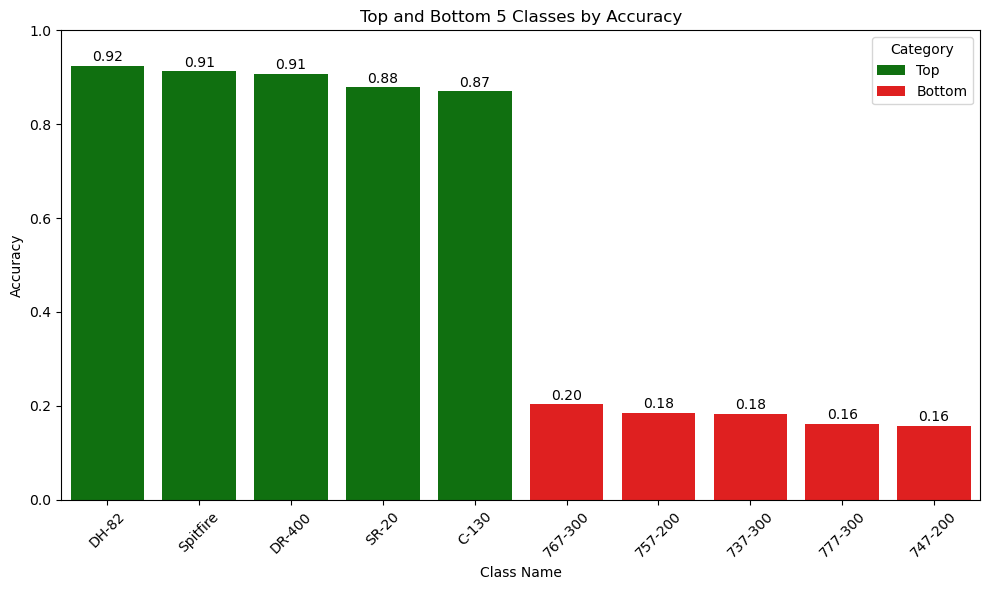

In [30]:
df_sorted = df_sorted.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Extract top 5 and bottom 5 classes
top5 = df_sorted.head(5).copy()
bottom5 = df_sorted.tail(5).copy()
top5['Category'] = 'Top'
bottom5['Category'] = 'Bottom'
df_vis = pd.concat([top5, bottom5], ignore_index=True)

# Plot 1: Seaborn barplot of accuracy with color-coded categories
plt.figure(figsize=(10, 6))
sns.barplot(data=df_vis, x='Class Name', y='Accuracy', hue='Category', dodge=False, palette={'Top': 'green', 'Bottom': 'red'})
plt.title('Top and Bottom 5 Classes by Accuracy')
plt.ylim(0, 1)
for i, row in df_vis.iterrows():
    plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
#plt.savefig("class_accuracy_visualization.png")
#print("Visualization saved as 'class_accuracy_visualization.png'.")


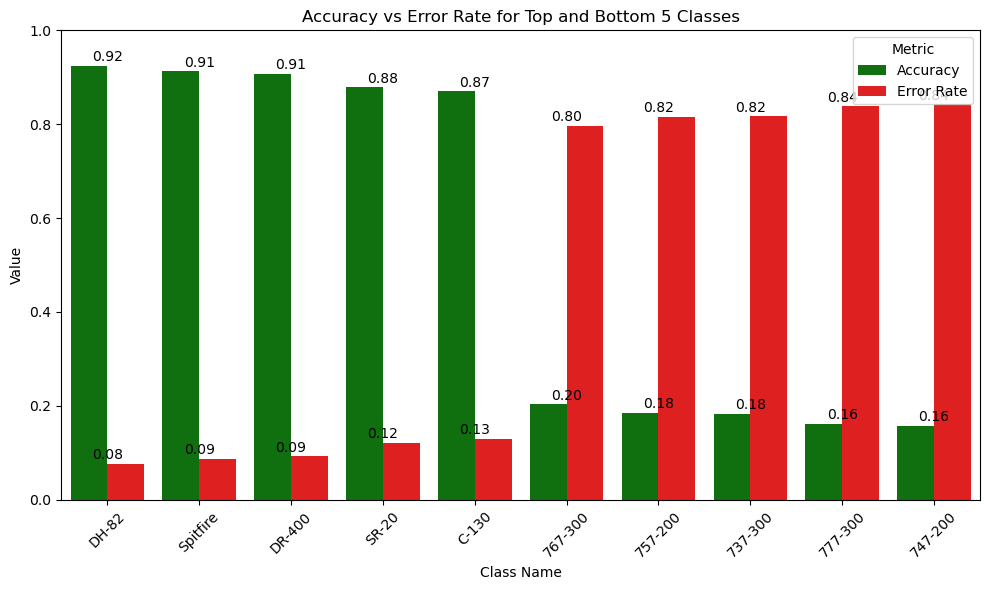

In [31]:
df_vis['Error Rate'] = 1 - df_vis['Accuracy']
df_melted = df_vis.melt(id_vars=['Class Name'], value_vars=['Accuracy', 'Error Rate'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Class Name', y='Value', hue='Metric', palette={'Accuracy': 'green', 'Error Rate': 'red'})
plt.title('Accuracy vs Error Rate for Top and Bottom 5 Classes')
plt.ylim(0, 1)
for i, row in df_melted.iterrows():
    plt.text(i % 10, row['Value'] + 0.01, f"{row['Value']:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("accuracy_error_comparison.png")
# plt.close()

# print("Visualizations saved as 'accuracy_barplot.png' and 'accuracy_error_comparison.png'.")



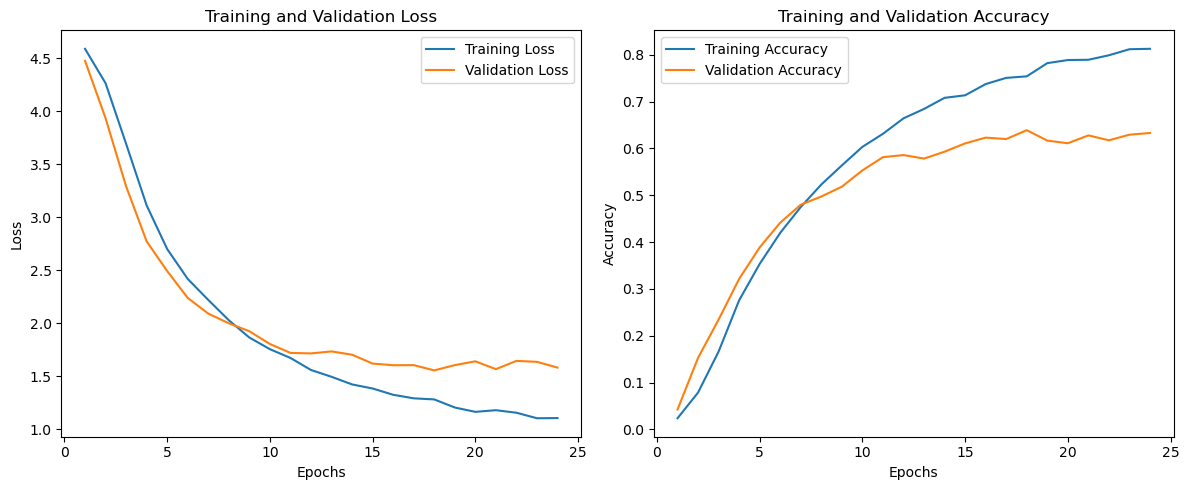

In [32]:
# Sample data (replace these lists with actual collected data)
# train_losses = [2.0, 1.8, 1.5, 1.2, 1.0, 0.8, 0.6, 0.5, 0.4, 0.3]
# val_losses = [2.1, 1.9, 1.6, 1.3, 1.1, 0.9, 0.7, 0.6, 0.5, 0.4]
# train_accuracies = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
# val_accuracies = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

ep = range(1, len(train_loss_lst) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ep, train_loss_lst, label='Training Loss')
plt.plot(ep, val_loss_lst, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(ep, train_acc_lst, label='Training Accuracy')
plt.plot(ep, val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

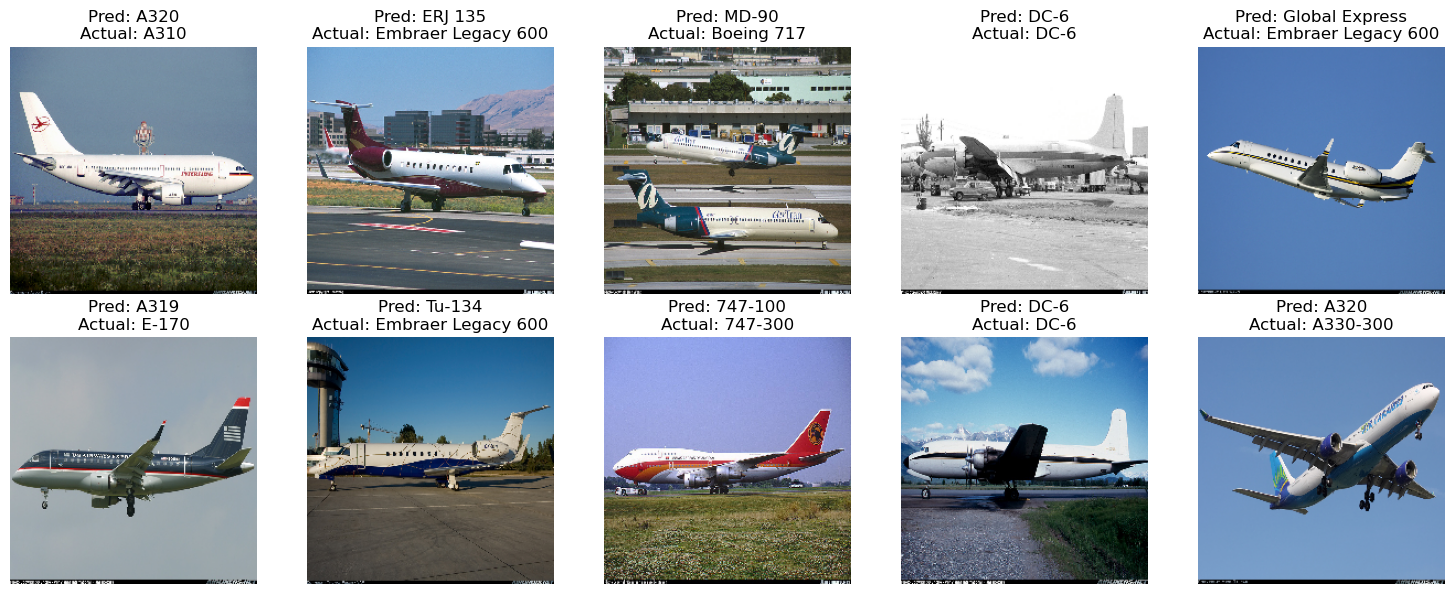

In [33]:
visualize_predictions(model, test_dataset, 10)


In [34]:
# your existing imports…
# from src.chih_dataloader import FGVCAircraftDataset
# from your_model_module import load_model, visual_prediction

app = dash.Dash(__name__)

# Pre-load or lazy-load your model + test set
# model = load_model("path/to/best_model.pth")        # replace with your loader
# test_dataset = FGVCAircraftDataset(
#     root="…", split="test", level="manufacturer"
# )

# Layout with a “view selector”
app.layout = html.Div([
    html.H2("FGVC Aircraft Dashboard"),
    dcc.RadioItems(
        id="view-selector",
        options=[
            {"label": "Class Overview",   "value": "overview"},
            {"label": "Model Prediction", "value": "prediction"},
        ],
        value="overview",
        labelStyle={"display": "inline-block", "marginRight": "20px"},
    ),
    html.Hr(),
    # Container for controls (dynamically replaced)
    html.Div(id="controls-container"),
    html.Hr(),
    # Container for outputs (images, figures, etc.)
    html.Div(id="output-container")
])

# 1) Dynamically swap in the appropriate controls
@app.callback(
    Output("controls-container", "children"),
    Input("view-selector", "value"),
)
def render_controls(view):
    if view == "overview":
        return [
            html.P("Dataset root:"),
            dcc.Input(
                id="path-input", type="text",
                placeholder="Enter dataset root path",
                style={"width": "60%"}
            ),
            html.Button("Load Dataset", id="load-button", n_clicks=0),
            html.Br(), html.Br(),
            html.Label("Select Level:"),
            dcc.Dropdown(id="level-dropdown",
                         options=[{"label": l.title(), "value": l} for l in LEVELS]),
            html.Br(),
            html.Label("Select Class:"),
            dcc.Dropdown(id="class-dropdown"),
        ]
    else:  # prediction view
        return [
            html.P("How many samples to predict?"),
            dcc.Input(
                id="num-samples-input", type="number",
                placeholder="Enter an integer", min=1, step=1, value=5
            ),
            html.Button("Run Prediction", id="predict-button", n_clicks=0),
        ]

# 2) Existing callbacks for Class Overview…
#    – load_dataset
#    – update_class_dropdown
#    – display_images

# 3) New callback: run visual_prediction when user clicks “Run Prediction”
@app.callback(
    Output("output-container", "children"),
    Input("predict-button", "n_clicks"),
    State("num-samples-input", "value"),
    prevent_initial_call=True
)
def on_predict(n_clicks, num_samples):
    # Call your function; assume it returns a list of Plotly figures
    figs = visual_prediction(model, test_dataset, num_samples)

    # Wrap each figure in a Graph component
    graphs = []
    for fig in figs:
        graphs.append(html.Div(dcc.Graph(figure=fig), style={"margin": "10px"}))
    return graphs

# 4) Make sure your “Class Overview” also writes into output-container
#    by updating display_images() to target output-container instead of its own div.

# Helper to pick a free port
def find_free_port():
    s = socket.socket()
    s.bind(('', 0))
    return s.getsockname()[1]



In [35]:
if __name__ == "__main__":
    app.run(debug=True, port=find_free_port())

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[34], line 51, in render_controls(view='overview')
     34 @app.callback(
     35     Output("controls-container", "children"),
     36     Input("view-selector", "value"),
     37 )
     38 def render_controls(view):
     39     if view == "overview":
     40         return [
     41             html.P("Dataset root:"),
     42             dcc.Input(
     43                 id="path-input", type="text",
     44                 placeholder="Enter dataset root path",
     45                 style={"width": "60%"}
     46             ),
     47             html.Button("Load Dataset", id="load-button", n_clicks=0),
     48             html.Br(), html.Br(),
     49             html.Label("Select Level:"),
     50             dcc.Dropdown(id="level-dropdown",
---> 51                          options=[{"label": l.title(), "value": l} f